In [21]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import transforms
import torch.nn.functional as F

In [22]:
cuda_available = torch.cuda.is_available()
cuda_available

True

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Initializing parameter

In [24]:
input_size=784   #28X28 pixel of image
hidden_size1=200 #size of 1st hidden layer(number of perceptron)
hidden_size2=150 #size of second hidden layer
hidden_size3=100 #size of third hidden layer
hidden_size=80   #size of fourth hidden layer
output =10       #output layer
bach_size=100
lr_rate=0.01

## Loading the dataset using Pytorch Dataset and Data Loader

In [25]:
transform = transforms.Compose([transforms.ToTensor()])
batch_size = 100

In [26]:
train_dataset = torchvision.datasets.MNIST('./content', train=True, download=True, transform=transform)

test_dataset= torchvision.datasets.MNIST('./content', train=False, download=False, transform=transform)

In [27]:
train_dataloader=torch.utils.data.DataLoader(dataset=train_dataset,
                                             batch_size=100,shuffle=True)

test_dataloader=torch.utils.data.DataLoader(dataset=test_dataset,
                                             batch_size=100,shuffle=True)

In [28]:
data=iter(train_dataloader)
samples,labels=next(data)
print(f"number of samples{samples.shape}")
print(f"number of labels {labels.shape}")

number of samplestorch.Size([100, 1, 28, 28])
number of labels torch.Size([100])


## Saving Images from dataset

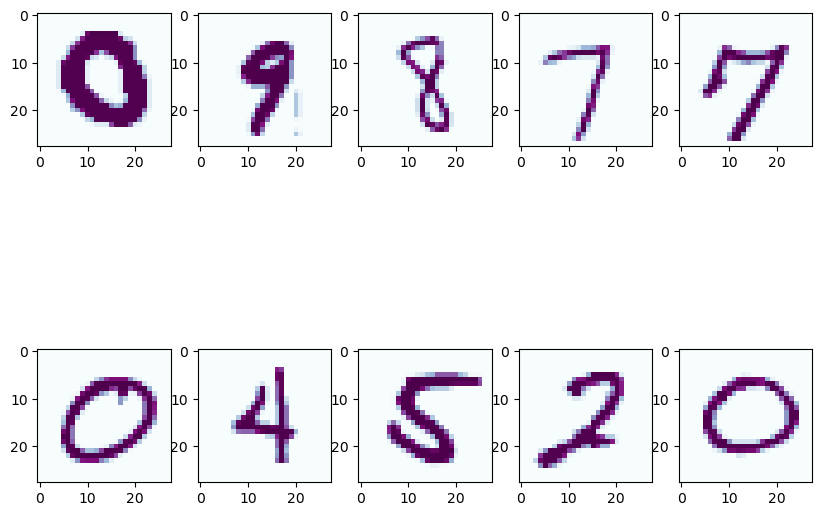

In [29]:
plt.figure(figsize=(10,8))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(samples[i][0],cmap='BuPu')
plt.savefig('numbers.png')

## Defining training pipeline

In [30]:
class MNIST(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2,
                 hidden_size3, hidden_size, output):
        super(MNIST, self).__init__()
        self.f_connected1 = nn.Linear(input_size, hidden_size1)
        self.f_connected2 = nn.Linear(hidden_size1, hidden_size2)
        self.f_connected3 = nn.Linear(hidden_size2, hidden_size3)
        self.f_connected4 = nn.Linear(hidden_size3, hidden_size)
        self.out_connected = nn.Linear(hidden_size, output)

    def forward(self, x):
        out = F.relu(self.f_connected1(x))
        out = F.relu(self.f_connected2(out))
        out = F.relu(self.f_connected3(out))
        out = F.relu(self.f_connected4(out))
        out = self.out_connected(out)
        return out

In [31]:
Mnist_model=MNIST(input_size,hidden_size1,hidden_size2,
                  hidden_size3,hidden_size,output)

#Move to GPU

if cuda_available:
    Mnist_model = Mnist_model.to('cuda')

In [32]:
print(Mnist_model.parameters)

<bound method Module.parameters of MNIST(
  (f_connected1): Linear(in_features=784, out_features=200, bias=True)
  (f_connected2): Linear(in_features=200, out_features=150, bias=True)
  (f_connected3): Linear(in_features=150, out_features=100, bias=True)
  (f_connected4): Linear(in_features=100, out_features=80, bias=True)
  (out_connected): Linear(in_features=80, out_features=10, bias=True)
)>


### Constructing loss and optimize for the model

In [33]:
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(Mnist_model.parameters(),lr=lr_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

## Train the model

In [34]:
num_epochs = 10  # Increase the number of epochs

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # Move images and labels to GPU if available
        if cuda_available:
            images = images.reshape(-1, 28*28).to('cuda')
            labels = labels.to('cuda')

        # Forward pass
        output = Mnist_model(images)

        # Calculate the loss using the defined loss function
        batch_loss = loss_function(output, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Printing progress
        if (i + 1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step {i+1}/{len(train_dataloader)}, Loss: {batch_loss.item()}")

    # Adjust the learning rate at the end of each epoch
    scheduler.step()

Epoch 1/10, Step 100/600, Loss: 0.1782906949520111
Epoch 1/10, Step 200/600, Loss: 0.1850179135799408
Epoch 1/10, Step 300/600, Loss: 0.3230809271335602
Epoch 1/10, Step 400/600, Loss: 0.2999780774116516
Epoch 1/10, Step 500/600, Loss: 0.10163688659667969
Epoch 1/10, Step 600/600, Loss: 0.13660800457000732
Epoch 2/10, Step 100/600, Loss: 0.17572592198848724
Epoch 2/10, Step 200/600, Loss: 0.17833925783634186
Epoch 2/10, Step 300/600, Loss: 0.13741841912269592
Epoch 2/10, Step 400/600, Loss: 0.12136625498533249
Epoch 2/10, Step 500/600, Loss: 0.12933452427387238
Epoch 2/10, Step 600/600, Loss: 0.17160826921463013
Epoch 3/10, Step 100/600, Loss: 0.1066812127828598
Epoch 3/10, Step 200/600, Loss: 0.10129097104072571
Epoch 3/10, Step 300/600, Loss: 0.10153409838676453
Epoch 3/10, Step 400/600, Loss: 0.2320118397474289
Epoch 3/10, Step 500/600, Loss: 0.04144567623734474
Epoch 3/10, Step 600/600, Loss: 0.08053871989250183
Epoch 4/10, Step 100/600, Loss: 0.07708954066038132
Epoch 4/10, Step 2

### Check model accuracy

In [35]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_dataloader:
        # Move images and labels to GPU if available
        if cuda_available:
            images = images.reshape(-1, 784).to('cuda')
            labels = labels.to('cuda')  # Also move labels to GPU

        output = Mnist_model(images)

        _, prediction = torch.max(output, 1)
        n_samples += labels.shape[0]
        n_correct += (prediction == labels).sum().item()

    accuracy = (n_correct / n_samples) * 100

In [36]:
accuracy

97.56

## Result prediction

In [37]:
predicted = []  # List to store predictions for all batches

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_dataloader:
        images = images.reshape(-1, 784).to('cuda')
        output = Mnist_model(images)  # Applying the model we have built
        _, batch_predictions = torch.max(output, 1)
        predicted.append(batch_predictions)

# Print all predictions
for batch_predictions in predicted:
    print(batch_predictions)

tensor([6, 4, 1, 0, 3, 4, 3, 1, 7, 3, 1, 6, 8, 1, 8, 3, 7, 7, 5, 2, 2, 1, 9, 4,
        9, 8, 1, 8, 0, 0, 9, 3, 8, 9, 0, 8, 2, 8, 0, 1, 1, 8, 3, 8, 4, 1, 6, 4,
        9, 9, 3, 5, 8, 2, 2, 9, 1, 3, 5, 1, 5, 9, 8, 1, 8, 9, 3, 4, 7, 8, 3, 1,
        6, 6, 8, 6, 1, 6, 3, 7, 1, 8, 7, 1, 2, 3, 6, 1, 5, 4, 3, 8, 1, 3, 5, 0,
        5, 1, 0, 3], device='cuda:0')
tensor([3, 3, 9, 8, 9, 0, 3, 8, 6, 5, 2, 0, 2, 5, 4, 8, 2, 0, 2, 0, 1, 4, 6, 0,
        4, 8, 7, 9, 1, 1, 9, 1, 5, 3, 3, 8, 7, 3, 7, 0, 3, 2, 9, 5, 9, 6, 3, 0,
        7, 1, 5, 8, 2, 1, 2, 3, 1, 9, 5, 8, 2, 1, 9, 3, 1, 3, 6, 3, 7, 0, 4, 7,
        0, 3, 8, 4, 5, 0, 6, 4, 8, 5, 2, 2, 0, 8, 8, 1, 5, 8, 8, 9, 5, 7, 4, 3,
        2, 9, 8, 9], device='cuda:0')
tensor([8, 9, 6, 9, 1, 3, 4, 7, 5, 9, 6, 1, 4, 8, 2, 2, 3, 7, 0, 2, 6, 0, 8, 6,
        4, 2, 6, 6, 5, 8, 9, 1, 7, 3, 7, 4, 2, 4, 3, 2, 7, 3, 4, 3, 4, 9, 9, 8,
        4, 2, 1, 9, 8, 9, 8, 8, 5, 3, 3, 9, 4, 3, 3, 0, 9, 5, 8, 9, 5, 5, 6, 5,
        4, 0, 2, 8, 7, 9, 1, 3, 6, 0, 7, 8, 